In [ ]:
#default_exp basics

# Linear models & causaling
> Playground unfinished for causal modelling on various kinds of generated synthetic data and causal graphs.

**Content in this notebook**
* generate your synthetic data → `obs`
* do some basic analysis of that data using a random forest → `model`
* create your hypothesis (causal graph) about your data using the networkx package → `causal_model`
* compute causal estimand, causal effect and potential refutations using the dowhy package

**References**

References for the dowhy package:
* Documentation: [here](https://microsoft.github.io/dowhy/)
* GitHub: [here](https://github.com/microsoft/dowhy)

Material which helped my introductory reading so far by :
* degeneratestate.org: [Pt I - potential outcomes](http://www.degeneratestate.org/posts/2018/Mar/24/causal-inference-with-python-part-1-potential-outcomes/) (contains definitions of ATE, ATT and ATC, among other things)
* degeneratestate.org: [Pt II - causal graphs & the backdoor criterion](http://www.degeneratestate.org/posts/2018/Jul/10/causal-inference-with-python-part-2-causal-graphical-models/)
* this youtube video [on backdoor paths](https://www.youtube.com/watch?v=F8vcki-uWJc) 
* Rubin et al. 2005 on [causal inference and potential outcomes](http://www.stat.unipg.it/stanghellini/rubinjasa2005.pdf)
* wiki article on the [average treatment effect (ATE)](https://en.wikipedia.org/wiki/Average_treatment_effect)
* this wiki article on [propensity score matching](https://en.wikipedia.org/wiki/Propensity_score_matching)  
* this wiki article on [regression discontinuity design](https://en.wikipedia.org/wiki/Regression_discontinuity_design)

**Open questions**
* How is matching or grouping done in categorical vs continuous treatment variable cases?
* How to visualize ATT, ATC and ATE and the reasoning for their potential  different applications? 
* Could the code easily be adjusted to extend the regression using arbitrary scikit-learn methods?
* Why is logistic regression used to compute the propensity score and not other methods?

In [ ]:
#hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#export
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import networkx as nx
from sklearn import ensemble, metrics
import dowhy as dw
from typing import List, Union

In [ ]:
#hide
mpl.style.use('bmh')

## Generating data → `obs`

### Data generating model: $ Y = a \cdot X_0 ^ b + c + X_1 $

In [ ]:
n = 1000
a,b,c = 1.5, 1., 0
target = 'Y'
obs = pd.DataFrame(columns=['X0', 'X1', target])
obs['X0'] = stats.uniform.rvs(loc=-1, scale=2, size=n)
# obs['X1'] = stats.norm.rvs(loc=0, scale=.1, size=n)
obs['X1'] = stats.uniform.rvs(loc=-.5, scale=1, size=n)
obs[target] = a * obs.X0 ** b + c + obs.X1

obs.head()

### Data generating model: $Y = a \cdot (X_0 \cdot X_1)^b + X_2^c + d$

In [ ]:
n = 1000
a,b,c,d = 1.5, 1., 1., 0.
target = 'Y'
obs = pd.DataFrame(columns=['X0', 'X1', 'X2', target])
obs['X0'] = stats.uniform.rvs(loc=-1, scale=2, size=n)
obs['X1'] = stats.norm.rvs(loc=0, scale=.1, size=n)
obs['X2'] = stats.norm.rvs(loc=0, scale=.1, size=n)
obs[target] = a * (obs.X0 * obs.X1) ** b + obs.X1 ** c + d

obs.head()

### Data generating model: $ Y = V \cdot \beta + W \cdot c_2 + X \cdot c_e \cdot V $

with 
$$t \equiv \varepsilon + W \cdot c_1 + Z \cdot c_z$$

* $V =$ treatment
* $Y =$ outcome
* $W =$ common cause (links treatment and outcome)
* $X =$ effect modifiers (only affect the outcome)
* $Z =$ [instrumental variables](https://en.wikipedia.org/wiki/Instrumental_variables_estimation) (only affect the outcome through the treatments) → [examples](https://pubs.aeaweb.org/doi/pdfplus/10.1257/jep.15.4.69)

In [ ]:
#export
class GenVars:
    def __init__(self, name:str, n_vars:int, **kwargs):
        self.name = name
        self.n_vars = n_vars
        for name, var in kwargs.items():
            setattr(self, name, var)
    @classmethod
    def get_obs(self): raise NotImplementedError
    def initialize(self): raise NotImplementedError
    def generate(self): raise NotImplementedError

        
class CommonCauses(GenVars):
    def __init__(self, name:str='W', n_common_causes:int=1, rv_mean:stats.rv_continuous=stats.norm,
                 rv_mean_kwargs:dict=None):
        super().__init__(name, n_common_causes)
        self.initialize(rv_mean, rv_mean_kwargs)
        
        
class Instruments(GenVars):
    def __init__(self, name:str='Z', n_instruments:int=1, rv_p:stats.rv_continuous=stats.uniform,
                 rv_p_kwargs:dict=None):
        super().__init__(name, n_instruments)
        self.initialize(rv_p, rv_p_kwargs)
        

class EffectModifiers(GenVars):
    def __init__(self, name:str='X', n_eff_mods:int=1, rv_mean:stats.rv_continuous=stats.uniform,
                 rv_mean_kwargs:dict=None):
        super().__init__(name, n_eff_mods)
        self.initialize(rv_mean, rv_mean_kwargs)

        
class Treatments(GenVars):
    def __init__(self, name:str='V', n_treatments:int=1, rv:stats.rv_continuous=stats.norm,
                 rv_kwargs:dict=None, cc:CommonCauses=None, ins:Instruments=None,
                 beta:Union[float, List[int], List[float], np.ndarray]=10):
        super().__init__(name, n_treatments)
        self.initialize(rv, rv_kwargs, cc=cc, ins=ins, beta=beta)

In [ ]:
n = 1000
n_common_causes = 2
n_instruments = 3
n_eff_mods = 2
n_treatments = 1
beta = 1  # max random value
target = 'Y'

In [ ]:
#export
def initialize(self, rv_mean:stats.rv_continuous, rv_mean_kwargs:dict):
        if not rv_mean_kwargs:
            rv_mean_kwargs = {'loc': 0, 'scale': .1}
        self.rv_mean = rv_mean(**rv_mean_kwargs)
        self.mean = self.rv_mean.rvs(size=self.n_vars)
        self.cov = np.eye(self.n_vars)
        self.rv = stats.multivariate_normal(mean=self.mean, cov=self.cov)
        
def generate(self, n:int): return self.rv.rvs(size=n)

@classmethod
def get_obs(self, n:int, n_common_causes:int):
    cc = self(n_common_causes=n_common_causes)
    vals = cc.generate(n)
    cc.obs = pd.DataFrame(data=vals, columns=[f'{cc.name}{i}' for i in range(n_common_causes)])
    return cc

CommonCauses.initialize = initialize
CommonCauses.generate = generate
CommonCauses.get_obs = get_obs

In [ ]:
%%time
cc = CommonCauses.get_obs(n, n_common_causes)
cc.obs.head()

CPU times: user 15.6 ms, sys: 0 ns, total: 15.6 ms
Wall time: 3.84 ms


,W0,W1
0,0.404247,-0.990520
1,0.988113,0.040550
2,-1.386640,-1.212049
3,1.254793,-0.268714
4,-0.634578,0.399088


In [ ]:
#export
def initialize(self, rv_p:stats.rv_continuous, rv_p_kwargs:dict):
    if not rv_p_kwargs:
        rv_p_kwargs = {'loc': 0, 'scale': 1}
    self.rv_p = rv_p(**rv_p_kwargs)
    self.p = rv_p.rvs(size=self.n_vars) # np.random.uniform(0, 1, num_instruments)

@classmethod
def get_obs(self, n:int, n_instruments:int):
    ins = self(n_instruments=n_instruments)
    vals = ins.generate(n)
    ins.obs = pd.DataFrame(data=vals, columns=[f'{ins.name}{i}' for i in range(n_instruments)])
    return ins

def generate(self, n:int):
    Z = np.zeros((n, self.n_vars))
    for i in range(self.n_vars):
        if (i % 2) == 0:
            Z[:, i] = np.random.binomial(n=1, p=self.p[i], size=n)  # ???
        else:
            Z[:, i] = np.random.uniform(0, 1, size=n)  # ???
    return Z

Instruments.initialize = initialize
Instruments.get_obs = get_obs
Instruments.generate = generate

In [ ]:
%%time
ins = Instruments.get_obs(n, n_instruments)
ins.obs.head()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.39 ms


,Z0,Z1,Z2
0,1.0,0.820640,0.0
1,1.0,0.446746,0.0
2,1.0,0.422746,0.0
3,1.0,0.184581,0.0
4,0.0,0.792348,0.0


In [ ]:
#export
def initialize(self, rv_mean:stats.rv_continuous, rv_mean_kwargs:dict):
    if not rv_mean_kwargs:
        rv_mean_kwargs = {'loc':-1, 'scale':1}
    self.rv_mean = rv_mean(**rv_mean_kwargs)
    self.mean = self.rv_mean.rvs(size=self.n_vars)
    self.cov = np.eye(self.n_vars)
    self.rv_obs = stats.multivariate_normal(mean=self.mean, cov=self.cov)

@classmethod
def get_obs(self, n:int, n_eff_mods:int):

    em = self(n_eff_mods=n_eff_mods)
    vals = em.generate(n)
    em.obs = pd.DataFrame(data=vals, columns=[f'{em.name}{i}' for i in range(n_eff_mods)])
    return em

def generate(self, n:int): return self.rv_obs.rvs(size=n)

EffectModifiers.initialize = initialize
EffectModifiers.get_obs = get_obs
EffectModifiers.generate = generate

In [ ]:
%%time
em = EffectModifiers.get_obs(n, n_eff_mods)
em.obs.head()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.58 ms


,X0,X1
0,-0.411759,-0.724200
1,0.806907,-0.903091
2,1.307164,-1.742818
3,-0.579316,-1.381260
4,0.136368,0.349929


In [ ]:
#export
def stochastically_convert_to_binary(x:float):
    p = 1/(1+np.exp(-x))  # sigmoid
    return np.random.choice([0, 1], size=1, p=[1-p, p])

In [ ]:
stochastically_convert_to_binary(.5)

array([0])

In [ ]:
#export
def initialize(self, rv:stats.rv_continuous, rv_kwargs:dict, 
               cc:CommonCauses=None, ins:Instruments=None,
               treatment_is_binary:bool=False,
               beta:Union[float, List[int], List[float], np.ndarray]=10):
    if not rv_kwargs:
        rv_kwargs = {'loc': 0, 'scale': 1}
    self.rv = rv(**rv_kwargs)
    self.n_common_causes = cc.n_vars if cc is not None else 0
    self.W = cc.obs.values.copy()
    self.n_instruments = ins.n_vars if ins is not None else 0
    self.Z = ins.obs.values.copy()
    self.treatment_is_binary = treatment_is_binary
    if not isinstance(beta, (list, np.ndarray)):
        self.beta = np.repeat(beta, self.n_vars)


def generate(self, n:int):
    
    t = self.rv.rvs(size=(n, self.n_vars))
    
    range_c1 = max(self.beta) * .5
    c1 = np.random.uniform(0, range_c1, 
                           size=(self.n_common_causes, 
                                 self.n_vars))
    
    range_cz = self.beta
    cz = np.random.uniform(low=range_cz - range_cz * .05,
                           high=range_cz + range_cz * .05, 
                           size=(self.n_instruments, self.n_vars))
    if self.n_common_causes > 0:
        t += self.W @ c1

    if self.n_instruments > 0:
        t += self.Z @ cz

    # Converting treatment to binary if required
    if self.treatment_is_binary:
        t = np.vectorize(stochastically_convert_to_binary)(t)
        
    return t
    
@classmethod
def get_obs(self, n:int, n_treatments:int, cc:CommonCauses, 
            ins:Instruments, beta:Union[float, List[int], List[float], np.ndarray]):
    treat = self(n_treatments=n_treatments, cc=cc, ins=ins,
                 beta=beta)
    vals = treat.generate(n)
    treat.obs = pd.DataFrame(data=vals, columns=[f'{treat.name}{i}' for i in range(n_treatments)])
    return treat

Treatments.initialize = initialize
Treatments.generate = generate
Treatments.get_obs = get_obs

In [ ]:
%%time
treat = Treatments.get_obs(n, n_treatments, cc, ins, beta)
treat.obs.head()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.33 ms


,V0
0,2.616050
1,-0.057216
2,1.979438
3,0.023992
4,2.018989


In [ ]:
#export
class Outcomes:
    def __init__(self, name:str='Y'):
        self.name = name
    
    def generate(self, treat:Treatments, cc:CommonCauses, 
                em:EffectModifiers, outcome_is_binary:bool=False):
        def _compute_y(t, W, X, beta, c2, ce):
            y =  t @ beta
            if cc.n_vars > 0:
                y += W @ c2
            if em.n_vars > 0:
                y += (X @ ce) * np.prod(t, axis=1)
            return y
        
        W = cc.obs.values
        X = em.obs.values
        t = treat.obs.values
        beta = treat.beta
        
        range_c2 = max(beta) * .5
        c2 = np.random.uniform(0, range_c2, size=cc.n_vars)
        
        if isinstance(beta, (list, np.ndarray)):
            range_ce = max(beta) * .5
        else:
            range_ce = beta * .5
        
        ce = np.random.uniform(0, range_ce, em.n_vars)
        
        y = _compute_y(t, W, X, beta, c2, ce)

        if outcome_is_binary:
            y = np.vectorize(stochastically_convert_to_binary)(t)
            
        return y
    
    @classmethod
    def get_obs(self, treat:Treatments, cc:CommonCauses, 
                em:EffectModifiers, outcome_is_binary:bool=False):
        out = self()
        vals = out.generate(treat, cc, em, outcome_is_binary)
        out.obs = pd.DataFrame(data=vals, columns=[f'{out.name}'])
        return out

In [ ]:
outcome_is_binary = False
out = Outcomes.get_obs(treat, cc, em, outcome_is_binary=outcome_is_binary)
out.obs.head()

,Y
0,1.404163
1,0.342496
2,1.102793
3,0.469746
4,2.223167


In [ ]:
obs = pd.concat((treat.obs, cc.obs, em.obs, ins.obs, out.obs), axis=1)
obs.head()

,V0,W0,W1,X0,X1,Z0,Z1,Z2,Y
0,2.616050,0.404247,-0.990520,-0.411759,-0.724200,1.0,0.820640,0.0,1.404163
1,-0.057216,0.988113,0.040550,0.806907,-0.903091,1.0,0.446746,0.0,0.342496
2,1.979438,-1.386640,-1.212049,1.307164,-1.742818,1.0,0.422746,0.0,1.102793
3,0.023992,1.254793,-0.268714,-0.579316,-1.381260,1.0,0.184581,0.0,0.469746
4,2.018989,-0.634578,0.399088,0.136368,0.349929,0.0,0.792348,0.0,2.223167


## Visualizing `obs`

In [ ]:
obs.describe()

,V0,W0,W1,X0,X1,Z0,Z1,Z2,Y
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.465296,0.100475,-0.130542,0.008895,-0.585974,0.805000,0.507214,0.238000,1.179813
std,1.204057,0.992407,1.037773,0.988501,1.020015,0.396399,0.282922,0.426072,1.598521
min,-2.339415,-3.267660,-3.571542,-2.874415,-4.047959,0.000000,0.002026,0.000000,-3.806755
25%,0.608202,-0.600980,-0.815770,-0.658849,-1.275486,1.000000,0.260859,0.000000,0.096035
50%,1.472026,0.114826,-0.095155,0.023061,-0.609953,1.000000,0.512605,0.000000,0.879824
75%,2.263248,0.781707,0.540700,0.711603,0.082860,1.000000,0.744506,0.000000,1.984080
max,5.860710,2.949236,2.812134,2.933076,2.726658,1.000000,0.995432,1.000000,8.964875


Covariation of the target variable with all other variables individually as observed (still being all confounded and what not)

In [ ]:
#export
def plot_target_vs_rest(obs:pd.DataFrame, target:str='Y'):
    in_cols = [col for col in obs.columns if target!=col]
    
    for in_col in in_cols:
        fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)
        ax.scatter(obs[in_col], obs[target], alpha=.1, marker='o')
        ax.set(xlabel=f'"{in_col}"', ylabel=f'"{target}"', 
               title=f'"{target}" vs "{in_col}"')
        plt.show()

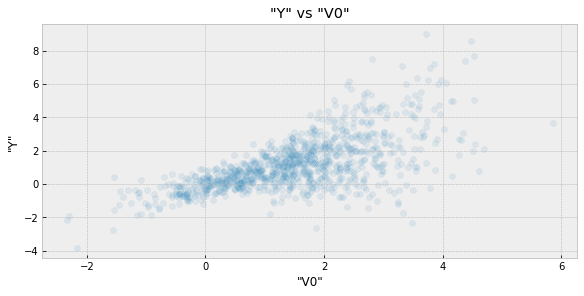

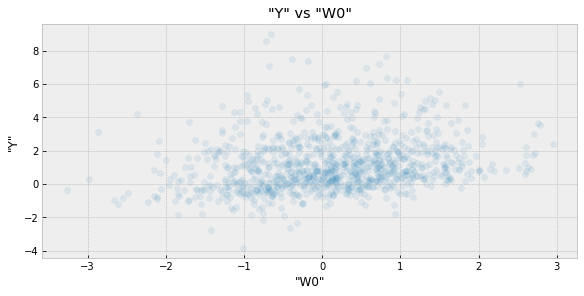

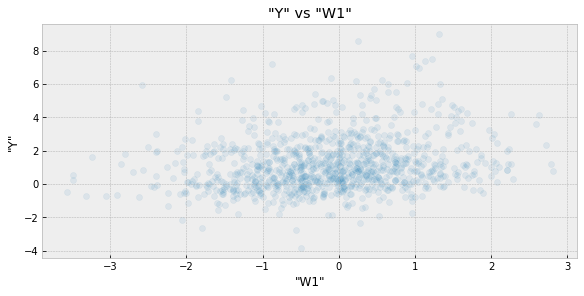

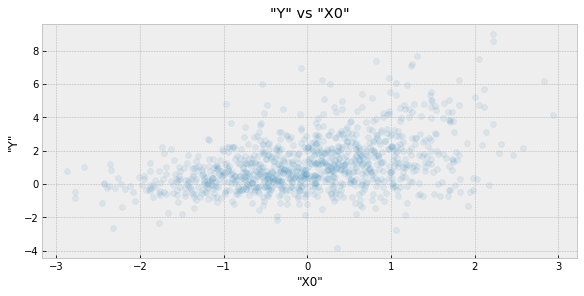

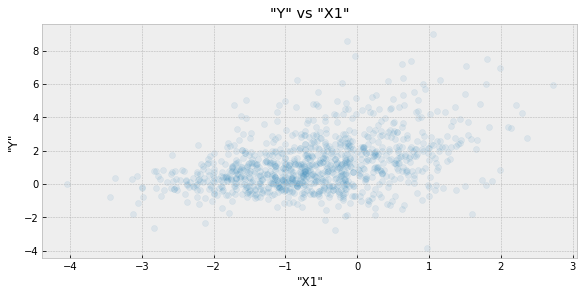

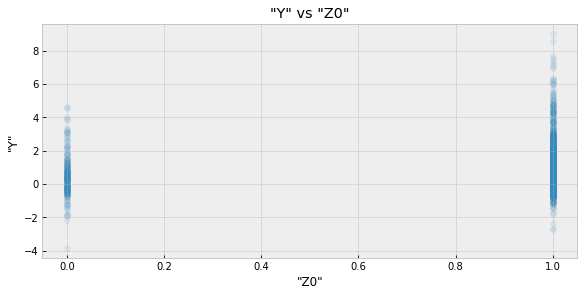

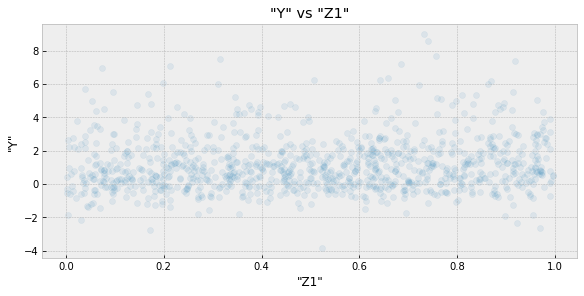

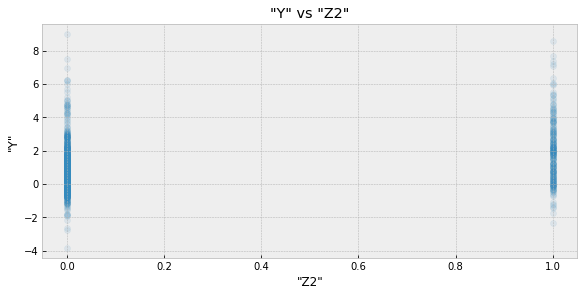

In [ ]:
plot_target_vs_rest(obs)

Distribution of each individual variables observed values

In [ ]:
#export
def plot_var_hists(obs:pd.DataFrame, bins:int=50):
    for col in obs.columns:
        fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)
        ax.hist(col, data=obs, bins=bins, density=True)
        ax.set(title=f'"{col}" distribution', xlabel=f'"{col}"',
               ylabel=f'Frequency')
        plt.show()

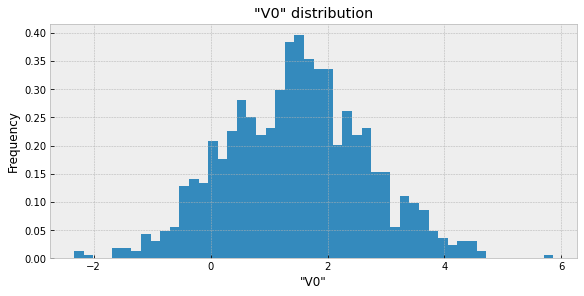

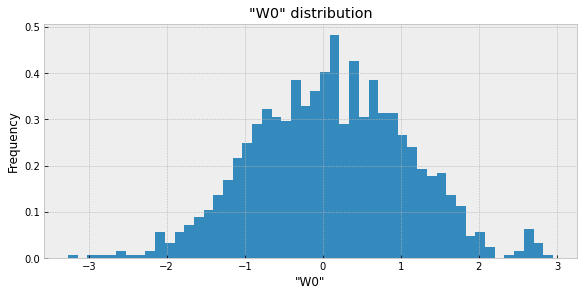

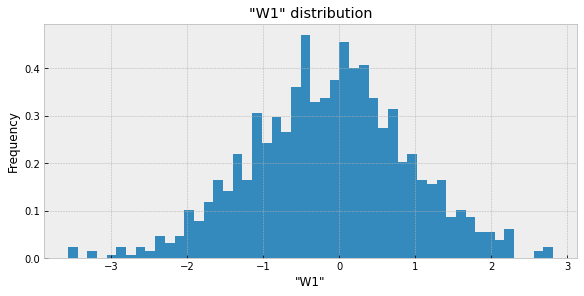

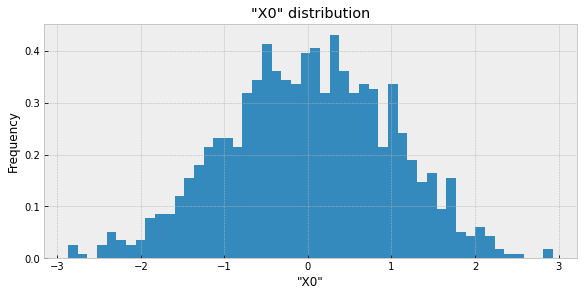

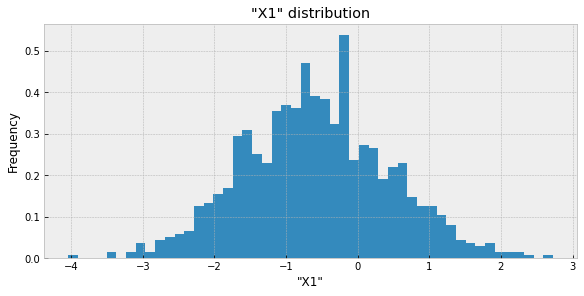

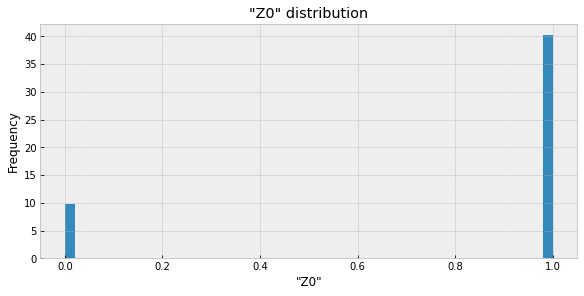

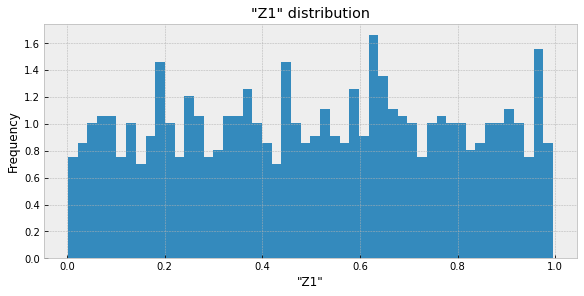

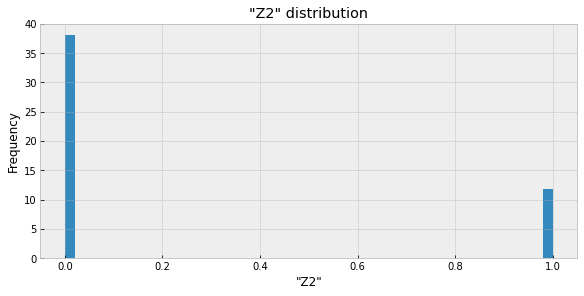

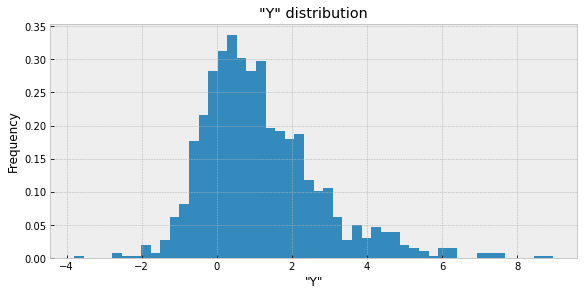

In [ ]:
plot_var_hists(obs)

Looking at correlations to get an idea of what interaction might be important

In [ ]:
#export
def show_correlations(obs:pd.DataFrame, method:str='spearman'):
    cols = obs.columns
    n = len(cols)
    fig, ax = plt.subplots(figsize=(8,8))
    im = ax.imshow(obs.corr(method=method))
    ax.set(xticks=range(n), xticklabels=cols,
           yticks=range(n), yticklabels=cols)
    fig.colorbar(im, ax=ax, shrink=.6, label=f'{method} correlation')
    plt.show()

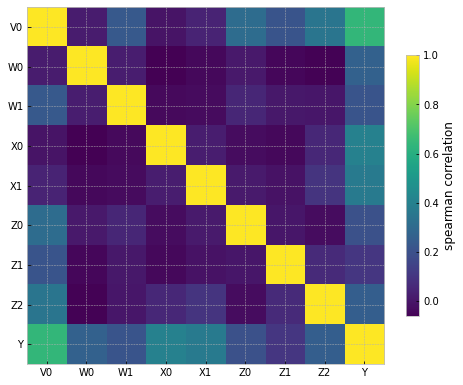

In [ ]:
show_correlations(obs)

## Random Forest model: feature importance & partial dependency

In [ ]:
#export 
def get_Xy(obs:pd.DataFrame, target:str='Y'):
    not_target = [c for c in obs.columns if c!=target]
    X, y = obs.loc[:, not_target].values, \
           obs.loc[:, target].values.ravel()
    return X, y, not_target

In [ ]:
X, y, not_target = get_Xy(obs, target=target)
model = ensemble.RandomForestRegressor(n_estimators=100, max_features='sqrt')
model.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

Getting a feeling for the quality of the model

In [ ]:
#export
def get_model_feel(model, obs:pd.DataFrame, target:str='Y',
                   bins:int=50):
    X, y, not_target = get_Xy(obs, target=target)
    _y = model.predict(X)
    Δ = _y - y
    
    fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)
    ax.hist(Δ, bins=bins, density=True)
    ax.set(xlabel='$\Delta = y_p - y_t$', ylabel='Frequency',
           title='Model prediction residuals')
    plt.show()
    
    for var in not_target:
        fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)
        ax.scatter(obs[var], obs[target], alpha=.1, marker='o', label='truth')
        ax.scatter(obs[var], _y, alpha=.1, marker='x', label='prediction')
        ax.set(xlabel=f'"{var}"', ylabel=f'"{target}"',
               title=f'Model prediction vs truth: "{var}"')
        ax.legend(loc='best')
        plt.show()

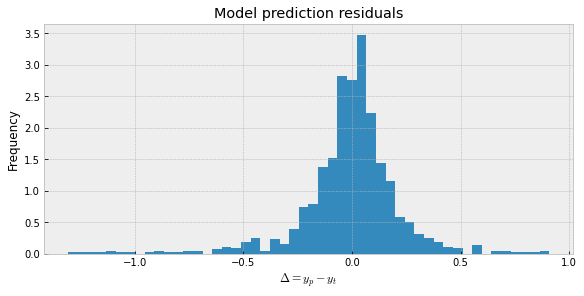

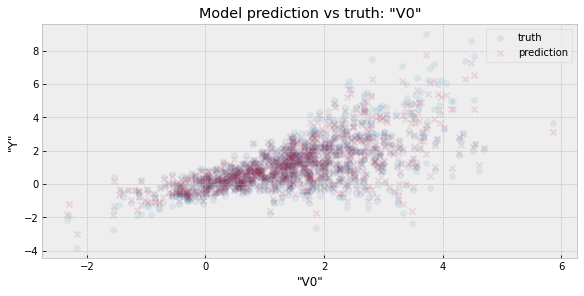

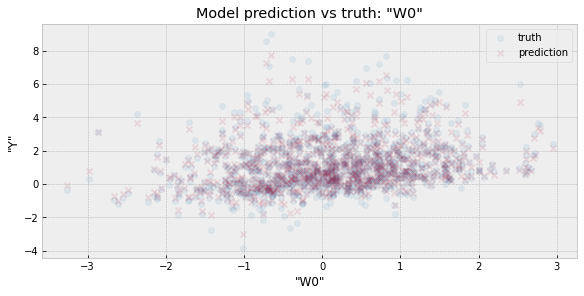

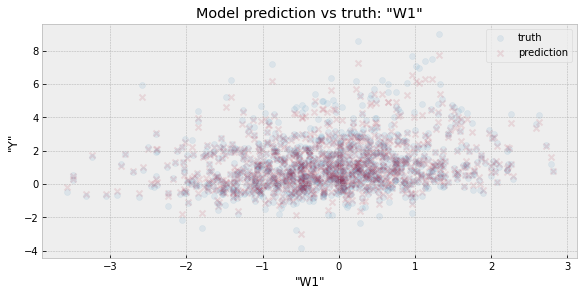

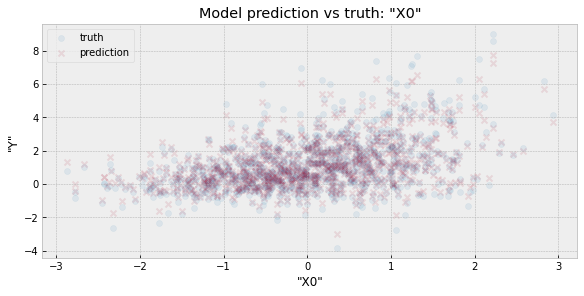

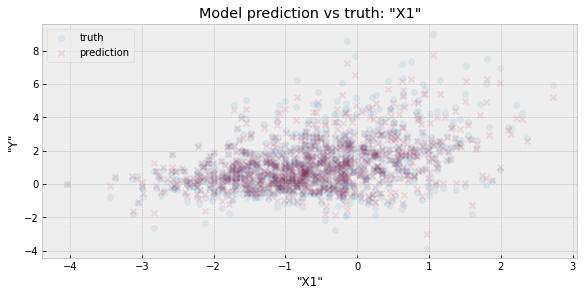

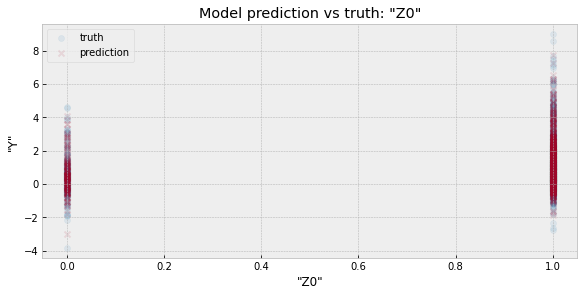

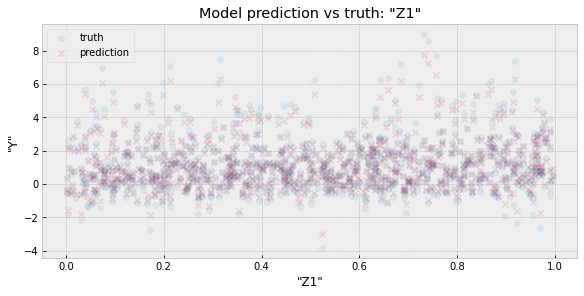

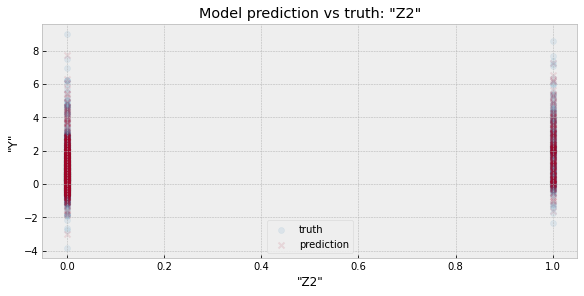

In [ ]:
get_model_feel(model, obs, target=target)

Looking at which features are particularly important for the prediction

In [ ]:
#export
def get_feature_importance(m, obs:pd.DataFrame, target:str='Y',
                           metric:callable=metrics.mean_squared_error):
    X, y, not_target = get_Xy(obs, target=target)
    n_obs, n_row = X.shape
    scores = {}
    for i in range(n_row):
        _X = X.copy()
        np.random.shuffle(_X[:,i])
        _y = m.predict(_X)
        scores[i] = metric(y, _y)
        
    scores = pd.DataFrame([{'variable': not_target[i], 'feature_importance': scores[i]} for i in scores]) 
    scores.sort_values('feature_importance', ascending=False, inplace=True)
    return scores

In [ ]:
fi_scores = get_feature_importance(model, obs,
                                   metric=metrics.mean_squared_error)
fi_scores.head()

,variable,feature_importance
0,V0,1.714640
3,X0,0.932858
4,X1,0.792039
1,W0,0.298732
2,W1,0.182284


Looking at partial dependencies

In [ ]:
#export
def get_partial_dependencies(model, obs:pd.DataFrame,
                             target:str='Y', max_num_obs:int=100, 
                             max_num_ys:int=10):
    
    assert max_num_ys > 0
    X, y, not_target = get_Xy(obs, target=target)
    n_obs, n_row = X.shape
    part_deps = {}
    
    for ix, var in enumerate(not_target):
        
        ys = {}
        idp_vals = np.unique(X[:,ix])
        n_u = len(idp_vals)
        
        step = n_u//max_num_ys if max_num_ys >= n_u else 1
        if step == 0: step = 1
        idp_vals = idp_vals[::step]
    
        if max_num_obs:
            if max_num_obs >= n_obs:
                ixs = np.arange(n_obs)
            else:
                ixs = np.random.choice(np.arange(n_obs), size=max_num_obs,
                                       replace=False)
        for i, val in enumerate(idp_vals):
            _X = X[ixs,:].copy()
            _X[:,ix] = val
            _y = model.predict(_X)
            ys[i] = _y.copy()

        part_deps[var] = pd.DataFrame({val: ys[i] for i,val in enumerate(idp_vals)})
    return part_deps

In [ ]:
%%time
part_deps = get_partial_dependencies(model, obs, target=target,
                                     max_num_obs=100, 
                                     max_num_ys=10)

CPU times: user 1min 21s, sys: 1.31 s, total: 1min 22s
Wall time: 1min 23s


In [ ]:
#export
def plot_partial_dependencies(part_deps:pd.DataFrame,
                              target:str='Y'):
    
    for var in part_deps:
        fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)
        x = part_deps[var].columns.values
        for i, row in part_deps[var].iterrows():
            obs_line, = ax.plot(x, row.values, alpha=.1, lw=1, color='black', label='single obs.')
        avg = part_deps[var].mean(axis=0)
        avg_line, = ax.plot(x, avg, lw=2, color='yellow', label='avg.')
        ax.set(xlabel=f'"{var}"', ylabel=f'"{target}"', title=f'Partial dependency plot "{target}" vs "{var}"')
        ax.legend(loc='best', handles=[obs_line, avg_line])
        plt.show()

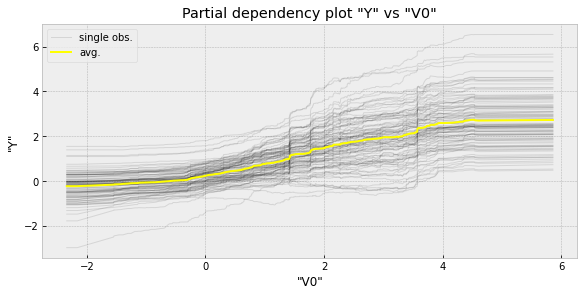

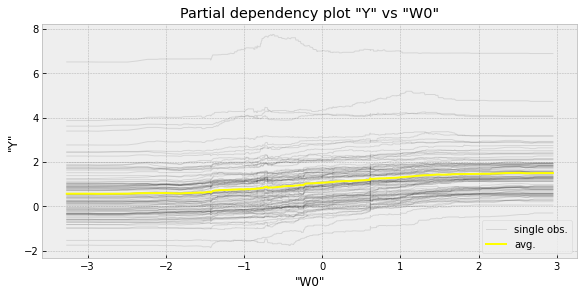

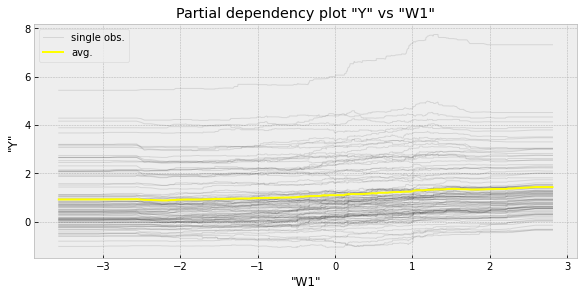

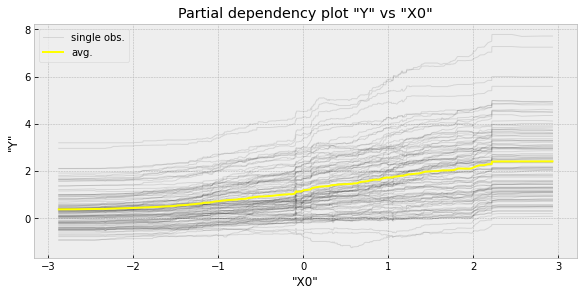

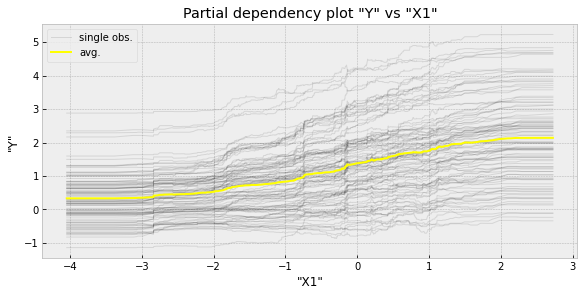

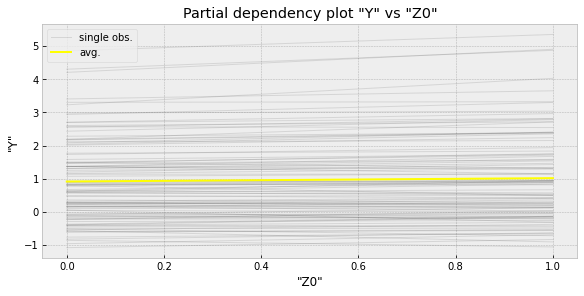

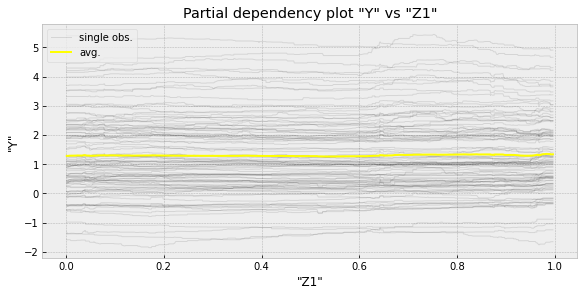

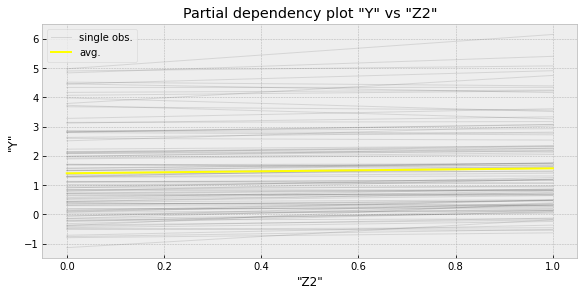

CPU times: user 10.5 s, sys: 3.67 s, total: 14.2 s
Wall time: 8.49 s


In [ ]:
%%time
plot_partial_dependencies(part_deps, target='Y')

## Generating a graphical model → `g`

In [ ]:
#export
class GraphGenerator:
    'Generates some specific directed graphs for `obs`'
    def __init__(self, obs:pd.DataFrame, target:str='Y'):
        self.not_targets = [col for col in obs.columns if col != target]
        self.target = target

### Causal graph: only $X_i \rightarrow Y$

In [ ]:
#export
def get_only_Xi_to_Y(self):
    g = nx.DiGraph()
    for var in self.not_targets:
        g.add_edge(var, self.target)
    return g

GraphGenerator.get_only_Xi_to_Y = get_only_Xi_to_Y

In [ ]:
gg = GraphGenerator(obs)
print(f'target var: {gg.target}, not target vars: {", ".join(gg.not_targets)}')

target var: Y, not target vars: V0, W0, W1, X0, X1, Z0, Z1, Z2


In [ ]:
g = gg.get_only_Xi_to_Y()

In [ ]:
#export 
import itertools
def get_Xi_to_Y_with_ccs_and_such(self, common_cause='W', effect_modifier='X',
                                  treatment='V', instrument='Z'):
    '''
    common cause → treatment
    common cause → outcome/target
    treatment → outcome/target
    instrument → treatment
    effect modifier → outcome/target
    '''
    g = nx.DiGraph()
    ccs = [v for v in self.not_targets if v.startswith(common_cause)]
    ems = [v for v in self.not_targets if v.startswith(effect_modifier)]
    treats = [v for v in self.not_targets if v.startswith(treatment)]
    inss = [v for v in self.not_targets if v.startswith(instrument)]
    
    g.add_edges_from([(cc, treat) for cc, treat in itertools.product(ccs, treats)])
    g.add_edges_from([(cc, self.target) for cc in ccs])
    g.add_edges_from([(treat, self.target) for treat in treats])
    g.add_edges_from([(ins, treat) for ins, treat in itertools.product(inss, treats)])
    g.add_edges_from([(em, self.target) for em in ems])
    return g
    

GraphGenerator.get_Xi_to_Y_with_ccs_and_such = get_Xi_to_Y_with_ccs_and_such

In [ ]:
g = gg.get_Xi_to_Y_with_ccs_and_such()

In [ ]:
layout = nx.random_layout(g)

In [ ]:
#export
def vis_g(self, g:nx.DiGraph, kind:str='spectral'): 
    try:
        layout = getattr(nx, f'{kind}_layout')(g)
    except AttributeError as ae:
        raise AttributeError(f'No nx.{kind}_layout found')
    nx.draw(g, layout=layout, with_labels=True)
GraphGenerator.vis_g = vis_g

In [ ]:
g.edges

OutEdgeView([('W0', 'V0'), ('W0', 'Y'), ('V0', 'Y'), ('W1', 'V0'), ('W1', 'Y'), ('Z0', 'V0'), ('Z1', 'V0'), ('Z2', 'V0'), ('X0', 'Y'), ('X1', 'Y')])

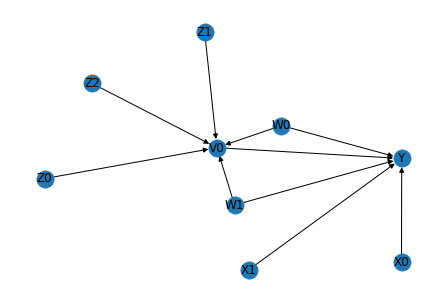

In [ ]:
gg.vis_g(g, kind='spiral')

## Using the graphical model `g` for causal estimates

First let's cast the graph into a form consumable by `dowhy.CausalModel`

In [ ]:
#export
def get_gml(self, g:nx.DiGraph):
    return ''.join([v for v in nx.readwrite.gml.generate_gml(g)]); gml

GraphGenerator.get_gml = get_gml

In [ ]:
gml = gg.get_gml(g); gml

'graph [  directed 1  node [    id 0    label "W0"  ]  node [    id 1    label "V0"  ]  node [    id 2    label "W1"  ]  node [    id 3    label "Y"  ]  node [    id 4    label "Z0"  ]  node [    id 5    label "Z1"  ]  node [    id 6    label "Z2"  ]  node [    id 7    label "X0"  ]  node [    id 8    label "X1"  ]  edge [    source 0    target 1  ]  edge [    source 0    target 3  ]  edge [    source 1    target 3  ]  edge [    source 2    target 1  ]  edge [    source 2    target 3  ]  edge [    source 4    target 1  ]  edge [    source 5    target 1  ]  edge [    source 6    target 1  ]  edge [    source 7    target 3  ]  edge [    source 8    target 3  ]]'

Instantiating the `causal_model`

In [ ]:
treatment = ['V0', ] # 'X1'
causal_model = dw.CausalModel(data=obs,  treatment=treatment, 
                       outcome=target, graph=gml)

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['V0'] on outcome ['Y']


Sanity checking that the model looks actually like what we had in mind with `g`, noticing that a node, U, was added between `treatment` and `outcome`, which is an unobserved confounder

INFO:dowhy.causal_graph:Using Matplotlib for plotting


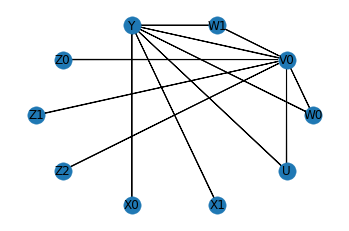

In [ ]:
causal_model.view_model()

Generating the expression for the estimand

In [ ]:
identified_estimand = causal_model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['U', 'W0', 'W1']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z0', 'Z1', 'Z2']


Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(Y|W0,W1))
d[V₀]                      
Estimand assumption 1, Unconfoundedness: If U→{V0} and U→Y then P(Y|V0,W0,W1,U) = P(Y|V0,W0,W1)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(Y, [Z0, Z1, Z2])*Derivative([V0], [Z0, Z1, Z2])**(-1))
Estimand assumption 1, As-if-random: If U→→Y then ¬(U →→{Z0,Z1,Z2})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1,Z2}→{V0}, then ¬({Z0,Z1,Z2}→Y)



**Estimating the effect between treatment and control**. For this we need to define what the `treatment_value` and `control_value` are, respectively. This is what for each group the treatment, e.g. X0, will be set to. If it is binary then this can be translated into "received a drug" or "received a placebo" by, for example, using 0 and 1 respectively.

How `dowhy.CausalModel` handles the treatment input is specified with the second part in the `method_name` argument, the part after the dot. For example, when the treatement is of a categorical nature you can use `'propensity_score_stratification'`, or when it is of a continuous nature you can use `'linear_regression'`.

Still unclear:

* Difference between `'regression_discontinuity'` and `'linear_regression'`?

* Difference between `'instrumental_variable'` and `'backdoor'`?

In [ ]:
# method_name = 'backdoor.propensity_score_stratification'
# method_name = 'backdoor.propensity_score_matching'
# method_name = 'backdoor.propensity_score_weighting'
# method_name = 'backdoor.linear_regression'
# method_name = 'iv.instrumental_variable'
# method_name = 'iv.regression_discontinuity'
method_name = 'iv.linear_regression'

effect_kwargs = dict(
    method_name=method_name,
    control_value = 0,
    treatment_value = 1,
    target_units = 'ate',
    test_significance = True
)
causal_estimate = causal_model.estimate_effect(identified_estimand,
                                        **effect_kwargs)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Y~V0+W0+W1+V0*X0+V0*X1


In [ ]:
print(causal_estimate)

*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(Y|W0,W1))
d[V₀]                      
Estimand assumption 1, Unconfoundedness: If U→{V0} and U→Y then P(Y|V0,W0,W1,U) = P(Y|V0,W0,W1)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(Y, [Z0, Z1, Z2])*Derivative([V0], [Z0, Z1, Z2])**(-1))
Estimand assumption 1, As-if-random: If U→→Y then ¬(U →→{Z0,Z1,Z2})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1,Z2}→{V0}, then ¬({Z0,Z1,Z2}→Y)

## Realized estimand
b: Y~V0+W0+W1+V0*X0+V0*X1
## Estimate
Value: 0.9999999999999973

## Statistical Significance
p-value: <0.001



For the simple linear case using `method_name =  backdoor.linear_regression'` with `control_value = 0` and `treatment_value = 1` we get the slope of the (linear) relationship between treatment and outcome, which is ~1.5, just as the value used to generate the data.

If however the exponent $b$ of $X_0$ in the data generating model is changed from 1 → 2 we see that suddenly the estimated value is bonkers.

**Trying to refute the observed causal effect**. I see this as sanity checking the causal graph created to capture the observed data by trying to poke holes into it in various ways, like adding potentially spurious correlations with a new variable or replacing the treatment with noise.

`method_name`:
* "random_common_cause": Adding a randomly-generated confounder
* "add_unobserved_common_cause": Adding a confounder that is associated with both treatment and outcome
* "placebo_treatment_refuter": Replacing the treatment with a placebo (random) variable)
* "data_subset_refuter": Removing a random subset of the data

In [ ]:
# method_name = 'random_common_cause'
# method_name = 'add_unobserved_common_cause'
method_name = 'placebo_treatment_refuter'
# method_name = 'data_subset_refuter'

refute_kwargs = dict(
    method_name=method_name,
    placebo_type = "permute",  # relevant for placebo refutation
    subset_fraction = .9,  # relevant for subset refutation
)

refute_res = causal_model.refute_estimate(identified_estimand, 
                                   causal_estimate, 
                                   **refute_kwargs)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Y~placebo+W0+W1+placebo*X0+placebo*X1


In [ ]:
print(refute_res)

Refute: Use a Placebo Treatment
Estimated effect:(0.9999999999999973,)
New effect:(0.21013674170611385,)

